# Signatures from Non-negative Matrix Factorisation
My basic idea was to use some of the profiles as a test case for a package 
I had been working on which describes samples as a linear mixture of "signatures",
allowing each sample to be a mix of signatures, opposed to discrete clustering 
like enterotypes.

My hope was to identify some areas I could improve a bit, as had been working with the
same test data for a while.

I had a go at two broad tasks:
* Learn new signatures from data
* Fit the data to an existing set of signatures

In [3]:
from helpers import read_metaphlans
import glob
import numpy as np

## Read MetaPhlAn data

In [4]:
metaphlan_abundance = read_metaphlans(
    files=glob.glob("data/metaphlan/*.tsv")
).fillna(0)

metaphlan_abundance.sum(axis=0)

SRX5707377_R1.fastq.gz.tsv     93.60515
SRX5707285_R1.fastq.gz.tsv     99.94716
SRX5707173_R1.fastq.gz.tsv    100.00000
SRX5707359_R1.fastq.gz.tsv     99.99999
SRX5707290_R1.fastq.gz.tsv    100.00000
SRX5707366_R1.fastq.gz.tsv     97.87840
SRX5707374_R1.fastq.gz.tsv     95.86151
dtype: float64

Unless I'm misunderstanding, MetaPhlAn's claim that each rank sums to 100
doesn't appear to hold true? Perhaps there has been some post-processing, or 
an unknown fraction removed?

Anyway, we'll total-sum-scale them to sum to 1.

In [5]:
metaphlan_tss = metaphlan_abundance / metaphlan_abundance.sum()
assert np.allclose(metaphlan_tss.sum(), 1.0)

## Signature generation

In [6]:
from enterosig.denovo import rank_selection, decompositions, plot_rank_selection

<Figure size 100x100 with 0 Axes>

In [7]:
metaphlan_ranksel = rank_selection(
    x=metaphlan_tss,
    ranks=range(2, 5)
)

100%|██████████| 300/300 [00:14<00:00, 21.05it/s]


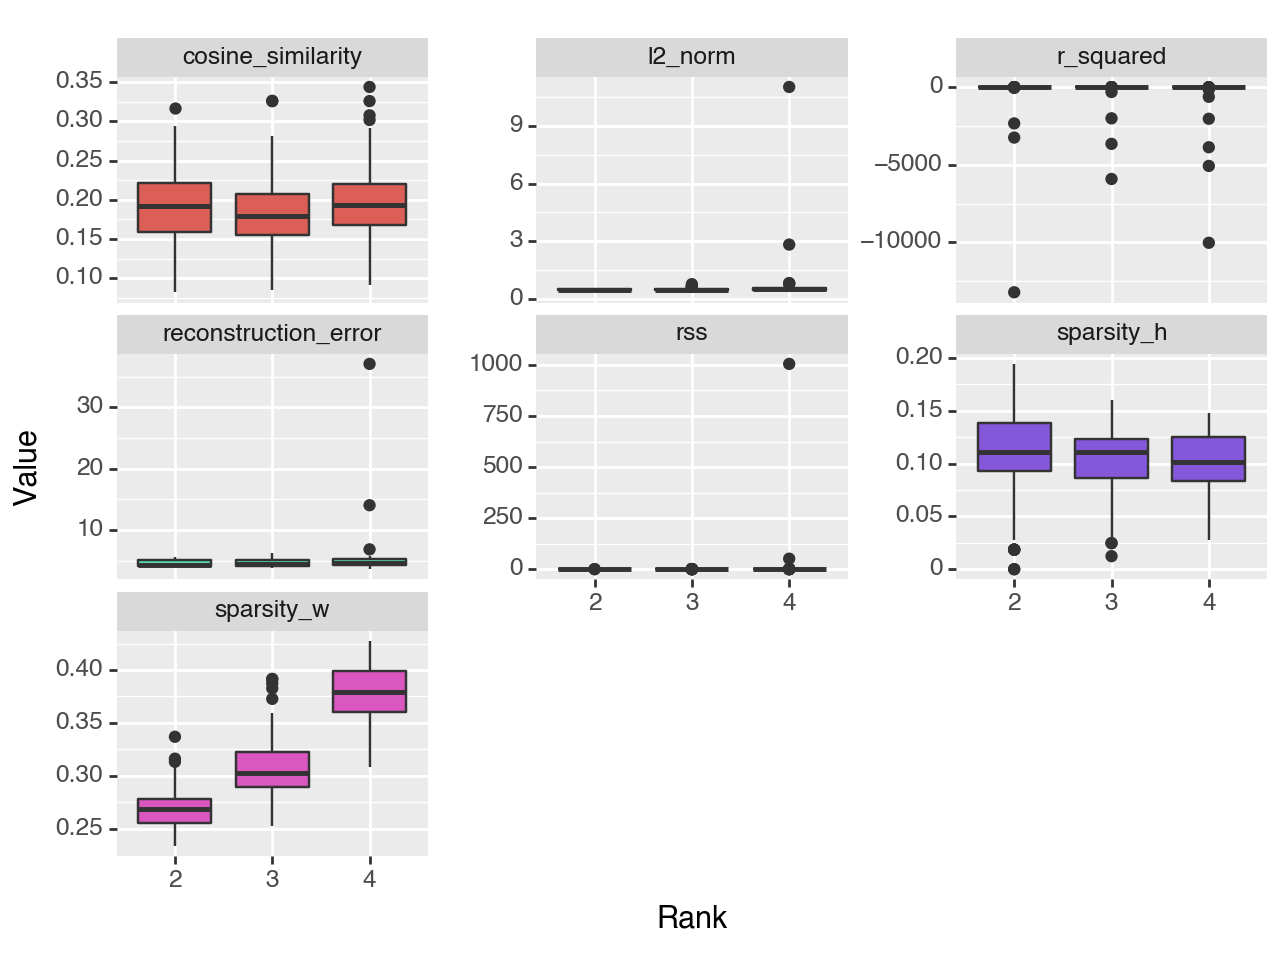

<Figure Size: (640 x 480)>

In [8]:
plot_rank_selection(metaphlan_ranksel, jitter=False)

100%|██████████| 20/20 [00:00<00:00, 322.51it/s]


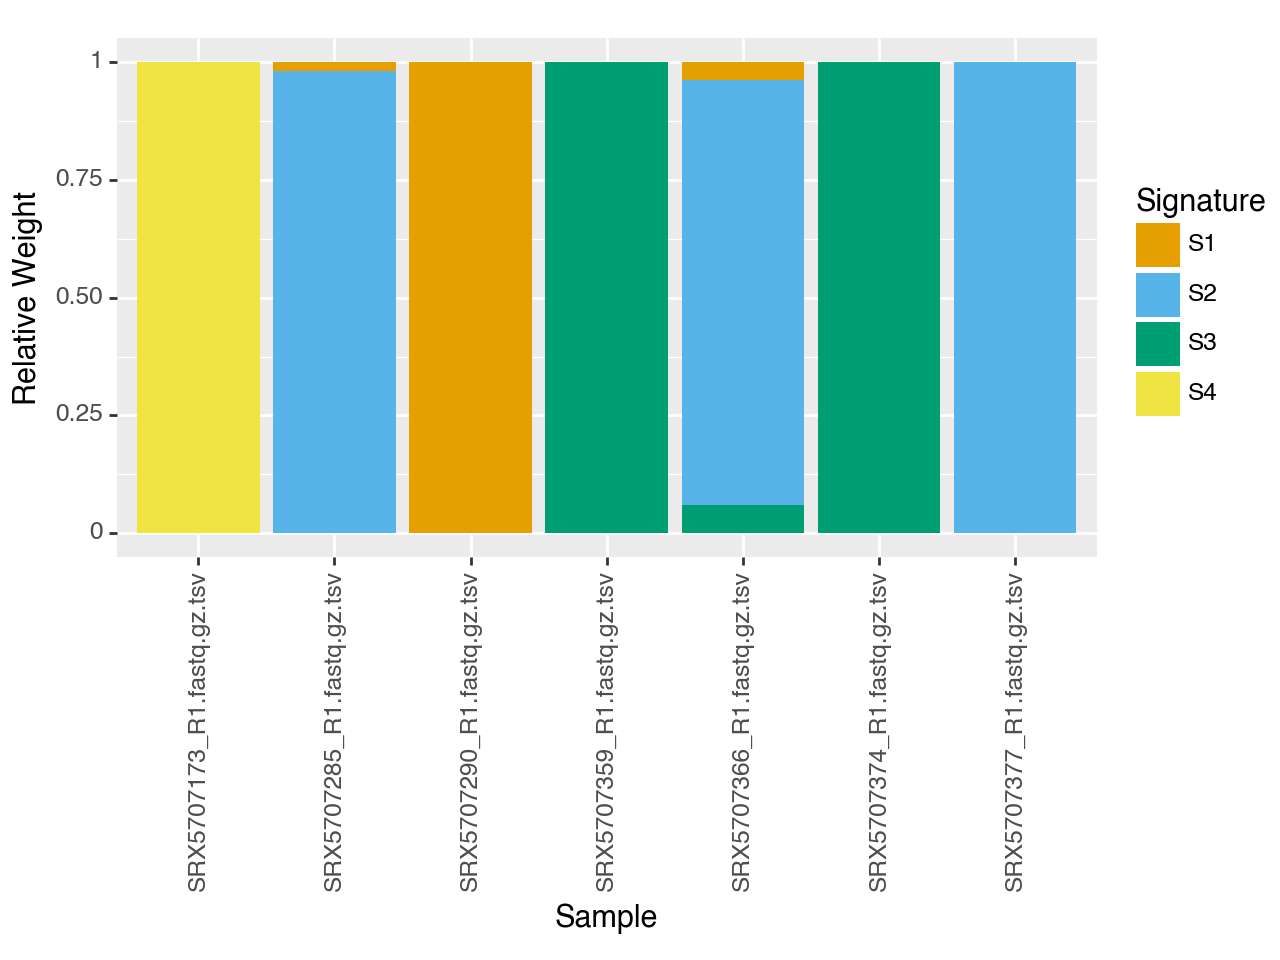

<Figure Size: (640 x 480)>

In [9]:
decomposition = decompositions(metaphlan_tss, ranks=[4], random_starts=20,
                               top_n=5)
decomposition[4][0].plot_relative_weight()

This data is really much too small to learn new decompositions from.
With rank close to number of samples, it is roughly learning one signature per sample, with only one appearing slightly mixed.
Instead, we can see whether we can fit it to the existing Enterosignatures model.

## KMCP Data
Can the KMCP profile be fitted to the 5ES model? They use GTDB taxonomy so should be amenable.

In [10]:
from helpers import read_kmcps
import logging
logging.basicConfig(level=logging.INFO)

kmcp_profile = read_kmcps(glob.glob("data/kmcp/*.cami.profile"),
                               rank="genus")
# Tidying - fill NA with 0, and total-sum-scale
kmcp_profile = kmcp_profile.fillna(0)
kmcp_profile = kmcp_profile / kmcp_profile.sum()
assert np.allclose(kmcp_profile.sum(), 1.0)
kmcp_profile.head()


,SRX5707290,SRX5707173,SRX5707359,SRX5707374,SRX5707285
taxpathsn,,,,,
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Escherichia,0.396413,0.000000,0.000000,0.000345,0.042555
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Shigella,0.365826,0.000000,0.000000,0.000000,0.000569
Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,0.126323,0.000000,0.236321,0.132621,0.031658
Bacteria;Firmicutes;Clostridia;Eubacteriales;Clostridiaceae;Clostridium,0.062961,0.001663,0.178344,0.001461,0.056667
Bacteria;Proteobacteria;Betaproteobacteria;Burkholderiales;Sutterellaceae;Sutterella,0.048477,0.000000,0.000000,0.000000,0.003731


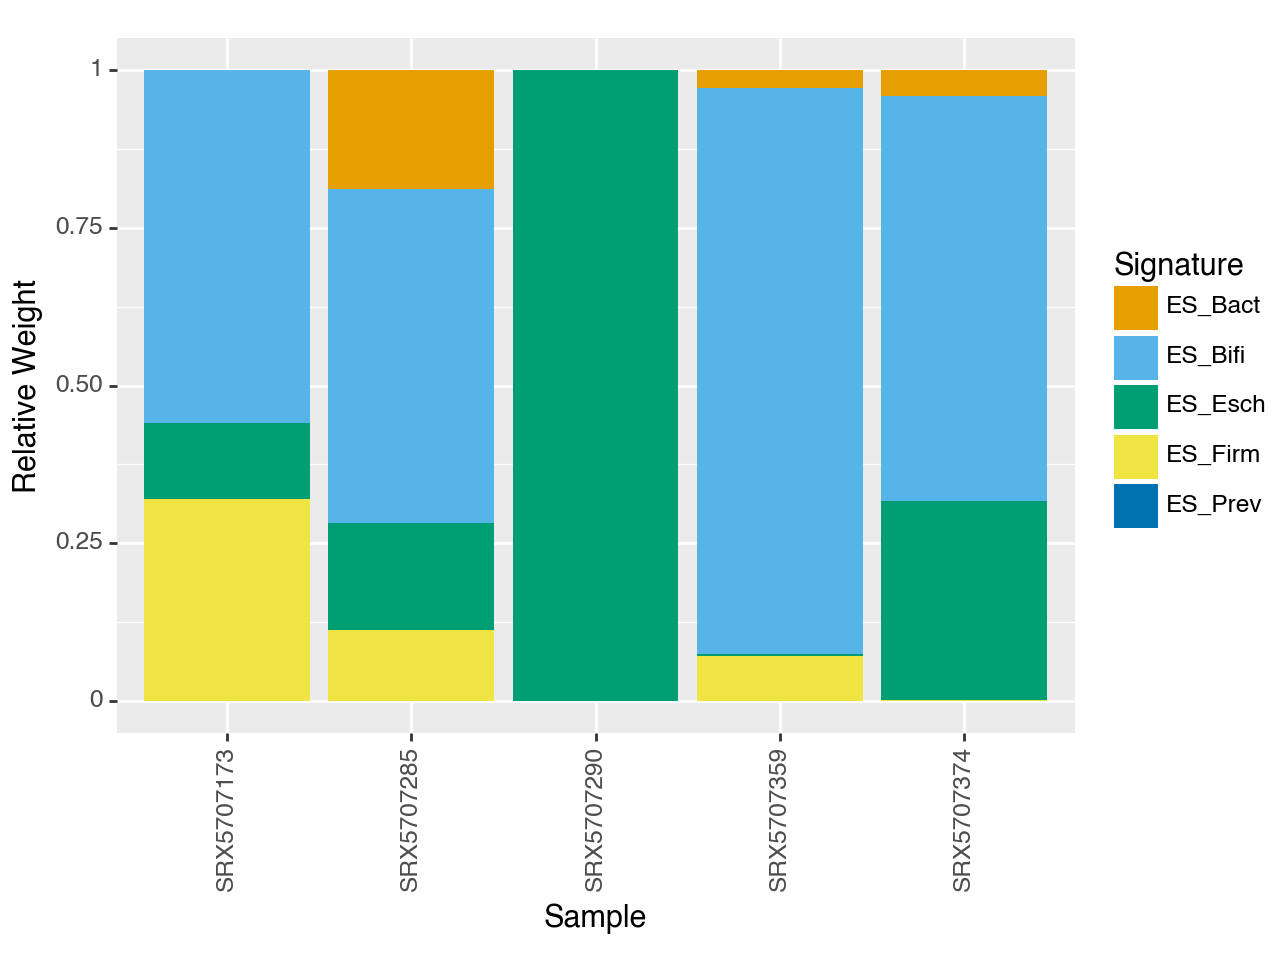

<Figure Size: (640 x 480)>

In [11]:
from enterosig import reapply, models
kmcp_es = reapply(
    kmcp_profile, model_w=models.five_es()
)
kmcp_es.plot_relative_weight()


In [12]:
kmcp_es.model_fit

SRX5707290    0.668471
SRX5707173    0.004929
SRX5707359    0.035236
SRX5707374    0.268599
SRX5707285    0.406293
Name: model_fit, dtype: float64

Most of the samples have very low model fit (roughly 0.4 or below), suggesting that either:
* The microbiomes of participants are in an unusual state
* It is unreliable to apply the model to data originating from a different profiling method
* The database used for classification is inconsistent (model is r207, unsure for KMCP)

**Things which can be improved, technically**
* Better warning of when poor matchup between input and model features when reapplying
* Some way for existing models to retain their colours (to match ES paper basically)
* `decomposition` argument `ranks` should take a single integer as well as an iterable
* `rank_selection` should validate upper bound of rank to ensure not greater than number of samples, maybe warn when too small
* Logging is a bit messy, should implement a module specific logger so not getting other modules messages mixed in (some are very verbose)
* Could use a visualisation of weight of model features in signatures
